In [4]:
# IMPORT LIBRARIES
from fractions import Fraction

from DTWA_Lib import *

%matplotlib notebook

# import faulthandler; faulthandler.enable()

# import gc
# gc.enable()

SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Author: Tamra Nebabu, tamramn@gmail.com

This notebook is meant to walk through the basic features of the coding suite for implementing the **Discrete Truncated Wigner Approximation (DTWA)**. 

# <font color="#388CD3"> Coding Library Contents </font> 


## Folder contents 
----
The DTWA package should contain the following:
- this tutorial
- Two python libraries:
    1. `DTWA_Lib.py`: contains functions for implementing the DTWA and visualization of dynamics; `DTWA_Lib` automatically imports `TamLib` but `TamLib` may also be independently used
    2. `TamLib.py`: more general functions for Exact Diagonalization (ED) numerics and operator manipulation for a system of many spins; notable features include a function for implementing a general XYZ Heisenberg model with power-law interactions and a class for implementation of symmetries
    3. **DTWA_Presentation**: keynote presentation and pdf containing more detailed notes about the DTWA and useful references

## Sections of Tutorial 
----
1. DTWA Background
    - Brief summary of the theory behind the discrete truncated wigner approximation
2. DTWA Implementation
    - Basics on how to run the DTWA
3. Comparing ED/Analytics and DTWA
    - Case Studies: Uniform Ising interactions and Power Law interactions with 2D Lattice Geometry
    - Scaling Behavior
4. Visualization
    - Histograms
    - Bloch sphere visualization
    - Animations
5. Benchmarking
    - Runtime
    - Convergence - Error of DTWA vs. 1) Number of Trajectories or 2) System Size $N$


## Package capabilities 
----
This package allows for the simulation of large $N$ discrete quantum dynamics for arbitrary geometries and power law interactions using the DTWA for 1) Ising Hamiltonian 2) XY Hamiltonian and 3) Transverse field Hamiltonian. Package also includes functions to facilitate exact diagonalization simulation of the dynamics of small systems.


## Basic Parameters and Functions
---

The library was developed primarily to simulate the quantum dynamics of large spin systems in lattice geometries, though the functions are flexible enough to accomodate non-lattice geometries. The code was designed with the following general Hamiltonian in mind: 

$$ H_{XYZ} = \sum_{i<j} \left(J^x_{ij} s^x_i s^x_j + J^y_{ij} s^y_i s^y_j \right)  + J^z_{ij} s_i^z s_j^z + \sum_i h^x_i s_i^x + \sum_i h^z_i s_i^z$$

This is a general **XYZ Hamiltonian with both longtiduinal ($h^z$) and transverse ($h^x$) fields**. For convenience, we shall refer to this as the **XYZ+TL Hamitlonian**. Both the fields $\mathbf{h}$ and the interaction energies $\mathbf{J}$ are generically site-dependent. The above Hamiltonian may be reduced to other commonly used Hamiltonians depending on the choice of parameters $(\mathbf{J^x}, \mathbf{J^y},\mathbf{J^z},\mathbf{h^x},\mathbf{h^z})$. Some examples are listed below:

1. **<font color=blue>Ising Hamiltonian</font>**: $\mathbf{J^{x,y}} = \mathbf{h^{x,z}} = 0$
2. **<font color=blue>XY Hamiltonian</font>**: $\mathbf{J^z} = \mathbf{h^{x,z}} = 0$
3. **<font color=blue>Transverse-field Ising Model</font>**: $\mathbf{J^x} = \mathbf{h^{x,z}} = 0$
4. **<font color=blue>Transverse field</font>**: $\mathbf{J^{x,y,z}} = \mathbf{h^z} = 0$

Similar parameters used in different functions are often defined with consistent names, and a brief description of frequently used variables and functions are described below based on their use.

### Implementing Different Lattice Geometries
The functions developed for DTWA and ED both accomodate general lattice geometries. If the parameters of the XYZ+TL Hamitlonian do not depend on the particular site or pair of sites being consisdered, i.e. $(\mathbf{J^x}, \mathbf{J^y},\mathbf{J^z},\mathbf{h^x},\mathbf{h^z})$ are all constants, then one has an effective 0-dimensional model. If the parameters instead depend on the sites/pairs of sites (i.e. power-law interactions or site-specific fields), then the $N$-spin system acquires a geometry.

The relevant helper methods for lattice geometries, which located in `TamLib`, are listed below:
1. ```python 
coord = def getLatticeCoord(d,L,a)```

> - returns a list of coordinates as a $N \times d$ array where $N$ is the total number of lattice points
- **<font color=red> L </font>**: a 1D list/tuple/numpy array giving the number of spins along each dimension of a rectangular lattice. If L is a simple integer, then this is taken to be the number of spins along each dimensions $d$, i.e. a square lattice is assumed
- **<font color=red> d </font>**: number of dimensions of the lattice.
- **<font color=red> a </font>**: a 1D list/tuple/numpy array giving the lattice spacing along each dimension. If $a$ is a simple integer, then uniform spacing is assumed.

2. ```python 
r_ij = def pairwiseDist(coord)```

> - given a list of coordinates (such as those returned by `getLatticeCoord()`, returns the pairwise distance between pairs of spins as a matrix (with 0's along the diagonal)

3. ```python 
r_ij,costh_ij = def get3DThetaDistCoord(coord)```

> - given a list of 3D coordinates (such as those returned by `getLatticeCoord()`, returns the pairwise distance between pairs of spins as a matrix $r_{ij}$ and the angle of the displacement vector with the quantization axis $z$ (with 0's along the diagonal)



### Implementing Power-Law Interactions

Generically, the $\mathbf{J}$'s can be an arbitrary matrices and $\mathbf{h}$'s may be arbitrary vectors. Typically, one considers a pairwise interactions that have a power law decay with the distance between the spins, $\mathbf{J}_{ij}(\mathbf{r}_i - \mathbf{r}_j) \sim 1/|\mathbf{r}_i - \mathbf{r}_j|^\alpha$ where $\alpha$ is the decay exponent.

There are several functions in `TamLib.py` which allow for the generation of power law interactions that depend on the spins' coordinates:


1. ```python 
Jfunc = def powerLawJfunc(j,alpha)```

> - given a scale $j$ and a decay exponent $\alpha$, returns a vectorized function $J(r,\theta)$ with power law dependence given by
$$ J_{ij}(\mathbf{r}_{ij},\theta_{ij}) = j\frac{1 - 3 \cos^2\theta}{|\mathbf{r}_{ij}|^\alpha} $$
- NOTE: Meant for 3D lattice geometries (where $\theta$ = angle with $z$-axis may be defined)

2. ```python 
Jfunc = def RydbergJfunc(j,alpha,rc)```

> - given a scale $j$, decay exponent $\alpha$, and critical distance $r_c$, returns a vectorized function $J(r)$ with power law dependence given by a "softened" step function
$$ J_{ij}(\mathbf{r}_{ij}) = \frac{j}{1 + \left({|\mathbf{r}_{ij}|}/{r_c}\right)^\alpha} $$

3. ```python 
J_ij = def getJij(coord,j,alpha,Jfunc=[])```

> - returns interaction matrix $J_{ij}$ with $j$ and $\alpha$ as parameters for the power law interaction $J(r,\theta)$ given by `powerLawJfunc` or the optional argument `Jfunc`
- `Jfunc` (optional): a vectorized function that computes the pairwise interaction, which only depends on pairwise distance $J_{ij}(r_{ij})$; meant to substitute for subsitute the function given by `powerLawJfunc`; when `Jfunc` is provided, the $j$ and $\alpha$ parameters are ignored (since these parameters presumably went into generating `Jfunc`)



### ED XYZ+LT Hamiltonian

`TamLib` contains a function that generates the XYZ+LT Hamiltonian as a matrix. All of the dynamics can then be computed from this Hamitlonian by standard ED techniques.

1. ```python 
H, opList, (Sx_tot,Sy_tot,Sz_tot) = Heisenberg_A2A(L, Jperp, Jz, hx, hz, PauliBool = False, opList=[], Jfunc=[], coord = [], alpha=[])```

> - **<font color=red> L </font>**: a 1D list/tuple/numpy array giving the number of spins along each dimension. If $L$ has only one element or is an integer, a the total system is assumed to have $L$ spins.
- **<font color=red> Jperp </font>**: a 1D list/tuple/numpy array giving the interaction energy scales in the plane orthogonal to the quantization axis, $J_\perp = (J_x, J_y)$. If `Jperp` is a single number, then we assume $J_x = J_y = J_\perp/2$.
- **<font color=red> Jz </font>**: interaction energy scale for zz interactions
- **<font color=red> hx </font>**: 1D list/tuple/numpy array giving the on-site transverse field; if `hx` is a single number, a uniform field is assumed
- **<font color=red> hz </font>**: 1D list/tuple/numpy array giving the on-site longitudinal field; if `hz` is a single number, a uniform field is assumed
- **<font color=red> PauliBool </font>** (optional): if True, then uses unitless Pauli operators $\boldsymbol{\sigma}$ in place of the spin operators $\mathbf{s}^\alpha = \frac{1}{2}\boldsymbol{\sigma}^\alpha$ in constructing the Hamiltonian
- **<font color=red> opList </font>** (optional): a tuple of lists of spin operators at each site (as `Qobj` or sparse matrices), such as those outputted by `genPauliList(L)` or `genSpinOpList(L)`. i.e. opList = $(sx, sy, sz)$ where each component is a list of size $N$.
- returns interaction matrix $J_{ij}$ with $j$ and $\alpha$ as parameters for the power law interaction $J(r,\theta)$ given by `powerLawJfunc`
- **<font color=red> Jfunc </font>** (optional): tuple of 3 functions $(\mathbf{J}^x,\mathbf{J}^y,\mathbf{J}^z)$ to compute $\mathbf{J}_{ij}$ interactions
- **<font color=red> coord </font>** (optional): $N \times d$ list of coordinates for each spin in $d$ dimensions. Must be consistent with the vector `L` in that the number of coordinates must be equal to $N = L_x L_y L_z$. If no coordinates are given, then uniform interactions are assumed (i.e. 0+1 dimensional model)
- **<font color=red> alpha </font>** (optional): decay exponent for power law interactions
- **returns the Hamiltonian matrix, a tuple of lists of the spin operators on each site, and a tuple of total spin operators $S_\alpha = \sum_i s_i^\alpha$**


### DTWA Dynamics

For the DTWA, the evolution is governed not by a Hamiltonian matrix, but by the classical equations of motion. Hence, for each type of Hamiltonian, one must define a new function that computes the evolution of the spin variables using the solution of the classical EOM. `DTWA_Lib` contains methods to compute the dynamics under the following Hamiltonians:

1. **<font color="#388CD3">Ising Hamiltonian with generic power law interactions</font>**
   $$ H = \sum_{i<j} J_{ij}^z \sigma_i^z \sigma_j^z $$
   ```python
    def IsingEvolve(configs,tvec,Jz,coord=[],Jfunc=[],alpha=[]):```
    - `configs`: $n_t \times N \times 3$ matrix containing the spin configuration (1x3 vector) of all $N$ spins in the system for each of the $n_t$ initial configurations
    - `tvec`: vector of times to compute the evolution for 
    - `Jz`: zz interaction energy scale
    - `coord` (optional): $N \times d$ list of coordinates for each spin where $d$ = # of dimensions. Size must be consistent with the total number of spins in the system $N$
    - `Jfunc` (optional): alternate function used to compute the $J_{ij}$ matrix; used as an argument to `getJij()`
    - `alpha` (optional): decay exponent for power law interactions
    - **Equations of motion are solved exactly**

   
2. **<font color="#388CD3">XY Hamiltonian with generic power law interactions</font>**
   $$ H = \sum_{i<j} \frac{J_{ij}^\perp}{2} \left(\sigma_i^x \sigma_j^x + \sigma_i^y \sigma_j^y\right) $$
     ```python
    def XYEvolve(initConfigs,tvec,Jperp,coord=[],Jfunc=[],alpha=[]):```
   - arguments are the same as above except the interaction energy scale is labeled by `Jperp`
   - **Evolution is computed from numerical integration of coupled ODEs**


3. **<font color="#388CD3">Transverse Field Hamiltonian with generic anisotropic on-site field</font>**
   $$ H = \sum_{i} h_i^x \sigma_i^x $$
     ```python
    def TFEvolve(initConfigs,tvec,h):```   
   - `h`: 1x$N$ vector containing the on-site transverse field $h_i$ on each spin
   - **Equations of motion are solved exactly**


Functions to compute the evolution under other Hamiltonians may be added to the repetoire of code. It is recommended that new functions follow the format of the methods implemented already. For a Hamiltonian whose classical dynamics may be computed exactly, the function should simply compute the variables at each later point in time using the appropriate analytic expression. For equations of motion with no analytic solution, the evolution of the spin variables may be computed numerically. The equations of motion are generically given by a set of coupled differential equations among all of the spin components. To numerically solve this, one considers all of the x, y, and z spin components to be part of a single vector representing the state of the system. Then, all one needs to do is define a function that takes in such a vector and computes its derivative according to the EOM. The values of the vector at later points in time (and therefore the state of the system) are found through numerical integration. An example of this can be found in the code for the XY Hamiltonian.

Lastly, evolution under a particular pulse sequence can be done easily by splitting up the time evolution into chunks, and then evolving under a particular Hamiltonian for each chunk.


### Squeezing
Both `TamLib` and `DTWA_Lib` contain methods to facilitate calculation of the squeezing parameter at each point in time under Ising dynamics. The squeezing parameter quantifies the reduced uncertainty in one quadrature of the plane orthogonal to the mean total spin vector. It is computed using

$$ \xi =  \frac{\sqrt{N} \Delta S_\text{min}}{\left| \mathbf{S}\right|^2}$$

where $\Delta S_\text{min}^2$ is the minimum variance along some axis in the orthogonal plane. A smaller squeezing parameter corresponds to better squeezing.

* For uniform-interaction Ising dynamics, there exists an analytic solution for the evolution squeezing parameter, which is computed by `def IsingSqueezing(N,Jz)` located in `TamLib`.
     ```python
      squeezing_func,Sx_func, Ssqx_func, Ssqy_func, yz_acomm_func = def IsingSqueezing(N,Jz): ```
       - returns vectorized functions for the squeezing parameter, total spin components $S_{x,y,z}$ and their squares $S_{x,y,z}^2$ that may be used to compute the evolution of any of these quantities
       -`N`: total number of spins in the system
       -`Jz`: uniform Ising interaction strength
* For Ising dynamics with anisotropic interactions, one must either use exact diagonalization or the DTWA to compute the evolution. 
    - ED: 
    ```python
       squeezing_opt,squeezing_dtwa_vec = def getEDIsingSqueezing(H,initState,tvec, opList=[], PauliBool = False): ```
       - `squeezing_opt`: best squeezing parameter for the squeezing parameters simulated for times in `tvec`
       - `squeezing_ed_vec`: vector containing the squeezing parameter at each time point in `tvec`
       - `H`: the Ising Hamiltonian (which should be diagonal for the Ising Hamiltonian)
       - `initState`: the initial state of the system given as a vector in the $z$ basis
       - `tvec`: times to compute the squeezing parameter for

    - DTWA:
       ```python
       squeezing_opt,squeezing_dtwa_vec = def getDTWASqueezingParam(N,nt,tvec,Jz,coord=[],Jfunc=[],alpha=[]): ```
       - `squeezing_opt`: best squeezing parameter for the squeezing parameters simulated for times in `tvec`
       - `squeezing_dtwa_vec`: vector containing the squeezing parameter at each time point in `tvec`
       - the input parameters parallel those for `IsingEvolve`

# <font color="#388CD3"> DTWA Background </font> 

## What it is
The DTWA is an alternate method for simulating quantum dynamics that is suitable for studying large systems with discrete degrees of freedom, such as a spin system with a large number of spins. The DTWA uses Monte-Carlo sampling to make a first-order approximation in $\hslash$ of the quantum dynamics in the Wigner phase space. Though the DTWA is only an approximation, it becomes increasingly accurate in the thermodynamic limit. One of the main benefits of the DTWA is that the accuracy of MC sampling is _not_ limited by the system size itself, but rather, by the number of samples. Furthermore, unlike other numeric methods for quantum simulation, it is equipped to handle systems in higher dimensions. This notebook will show examples of how one can run the DTWA and compare it to results obtained using exact diagonalization (ED) with smaller system sizes. This tutorial will focus on simulating systems with spin-1/2 degrees of freedom, since larger spin dof can be reduced to spin-1/2 representations.

## Procedure (Behind the Scenes)
-----

Here, we shall describe the prodecure behind the code that implements the DTWA.

1. Choose an initial (pure or mixed) state of the system and represent it as a quasiprobability distribution over discrete phase space. For a system of Ising spins, a salient choice for the discrete phase space variables are $$ \tilde{Z} = \mathbb{1}-\frac{1}{2}\sigma^Z \\ \tilde{X} = \mathbb{1}-\frac{1}{2}\sigma^X \\ $$ These are the discrete phase space analogs of the $(q,p)$ coordinates assigned to points in continuous phase space. For a single spin, the quasiprobability distribution represents the state of the spin by keeping track of 4 "joint probabilities": 1) $\mathbb{P}(X,Z = ++)$ 2) $\mathbb{P}(X,Z = +-)$ 3) $\mathbb{P}(X,Z = -+)$ and 4) $\mathbb{P}(X,Z = --)$. This is the discrete Wigner function of the system, and it differs from a classical joint probability distribution in that the "joint probabilities" may be negative. **However, in order for the DTWA to work, the initial Wigner distribution must be strictly positive, so that one can appropriately sample from it like a regular probability distribution.** <br><br> The general formula for computing the discrete Wigner function $W_\alpha$ for an arbitrary state (pure or mixed) is as follows: <br> <br> $$ W_\alpha = Tr(\rho A_\alpha) \\~\\ \alpha = \{(0,0), (1,0), (0,1), (1,1) \}  \\~\\  A_\alpha = 1 + \mathbf{r}_\alpha \cdot \boldsymbol{\sigma} \\~\\ r_{00} = (1,1,1) \\ r_{10} = (1,-1,-1) \\ r_{01} = (-1,-1,1) \\ r_{11} = (-1,1,-1) \\ $$ Where $W_\alpha$ is a vector whose components are the 4 joint quasiprobabilities that represent the state, $\rho$ is the standard quantum mechanical density matrix, and $A_\alpha$ is a set of 4 operators called **phase-point operators** whose expectation values yields the 4 joint quasiprobabilities. The parameter $\alpha$ is simply a label to denote which point in $\tilde{Z}$-$\tilde{X}$ phase space one is looking at. For instance, the probability associated with coordinate $(\tilde{Z},\tilde{X}) = (0,0)$ represents the probability that the state will be observed to have a +(1/2) eigenvalue for both $\sigma^Z$ and $\sigma^X$. The Wigner function for a system of many spins is computed analogously, with $\rho$ now representing the density matrix of the total system and $A_{\boldsymbol{\alpha}}$ defined for each for each of the $4^N$ coordinates of phase space, $\boldsymbol{\alpha} = (\alpha_1, \alpha_2, \dots, \alpha_N)$. <br><br> Since the DTWA requires that one has positive probabilities for the initial Wigner function, in most cases, one can immediately write down the initial distribution. For example, for $N$ spins all pointing in the $x$ direction, $W_\alpha$ factories into a product of the inidividual spin Wigner functions $W_\alpha = \prod_i w_\alpha^{(i)}$ for each spin $i$ with $w_{00}^{(i)} = w_{10}^{(i)} = 1/2$ and $w_{01}^{(i)} = w_{11}^{(i)} = 0$ for all spins $i$. In other words, each spin is observed to have a +1 $\tilde{X}$ eigenvalue with probability 1, with a (1/2) probability of being observed with $\tilde{Z} = \pm 1$. <br><br> 

2. Initialize a list of system configurations based off of the initial Wigner quasiprobability distribution. Each spin is assigned a semiclassical spin vector $\mathbf{s} = (s^x, s^y, s^z)$ according to the particular $N$-spin configuration. A factorizable inital state implies that the spins may be independently drawn from the single-spin joint probability distribution. A list of $N$ spin vectors represents ONE sample or system configuration. A list of $n_t$ sample configurations will be used to generate $n_t$ trajectories for the DTWA. <br><br> 

3. Calculate the evolution of the Wigner function in time by solving the classical equations of motion (EOM) for each spin vector $\mathbf{s}_i$. The classical EOM for each spin component are given by the Poisson bracket of the spin component and the Hamiltonian: $$ \dot{s}_i^\alpha (t) = \{s_i^\alpha (t),H(t)\} = 2\sum_{\beta} \epsilon_{\alpha,\beta,\gamma}s_i^\gamma \frac{\partial H}{\partial s_i^\beta} $$ where $i$ indexes the spin, the Greek letters index the component/direction x,y,or z, and $\epsilon_{\alpha,\beta,\gamma}$ is the antisymmetric Levi-Civita tensor. Generically the above expression is a set of coupled differential equations (each spin component $\dot{s}_i^\alpha$ may depend on other spins $s_j^\chi$, $\chi\neq \alpha$). However, in certain cases like the Ising Hamiltonian or simple field Hamiltonians the equations of motion simplify. In general, the EOM give you a recipe for how the all of the spin components transform at each time step. This is used to compute the trajectory of an $N$-spin configuration over time for each of the $n_t$ initial sample configurations. **The DTWA library provides methods for implementing time evolution under the 1) Ising Hamiltonian 2) XY Hamiltonian 3) Transverse field Hamiltonian.**
<br><br> 

4. Now the dynamics of any expectation value may be computed classically from our set of $n_t$ samples. For instance, the square of the total spin in the $y$ direction $\langle S_y^2 (t) \rangle$ may be computed by calculating $S_y$ for each of the $n_t$ samples, and taking the mean. Doing this for each time step yields the evolution of the expectation value.



# <font color="#388CD3"> DTWA Implementation </font> 

As an example, we will show how to execute the DTWA to simulate dynamics under a general Ising Hamiltonian

$$ H = \sum_{i<j} J_{ij} \sigma_i^z \sigma_j^z $$

Note that in the expression above, the interactions are generically different for different pairs of spins.

NOTE: Throughout this tutorial, we assume no self-interactions, i.e. the diagonal elements $J_{ii} = 0$. The functions provided in the coding library that compute power-law interactions also assume no self-interaction terms.


## Initialization ##
----

As a basic example, we show how to initalize a system of spins all pointing in the $x$ direction. We take advantage of a method `genInitConfigs(L,nt,axis=initAxis)` which generates a uniform probability distribution of $N$ spins all pointing in the direction given by `initAxis`. The object return is a 3D numpy array with dimensions $(n_t, N, 3)$ where `nt` is the number of initial $N$-spin configurations, where each spin has 3 components.


In [5]:
## DTWA PARAMS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
N = 10
nt =  10**4
initAxis = "x"

# generate inital spin configs
initConfigs = genInitConfigs(N,nt,axis=initAxis)

As a quick check that we indeed have a spin-polarized state in the $x$ direction, we can see if all the individual spins have an $s^x$ component that is $\frac{1}{2}$, and that y and z components are roughly evenly distributed betweem $\pm \frac{1}{2}$. For simplicity, we shall examine only one of the $n_t$ samples. The section on visualization shows how one can plot the probability distribution over the $n_t$ samples

Check x components: True


<IPython.core.display.Javascript object>


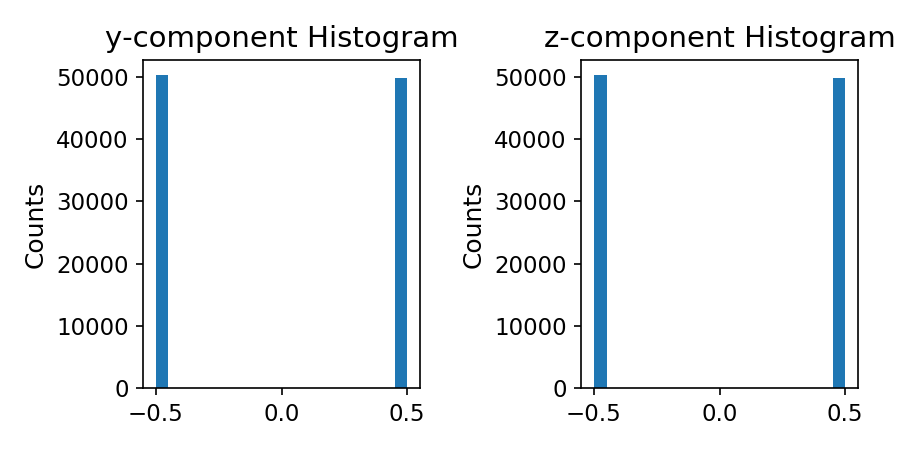

In [6]:
print("Check x components: %s" % np.all(initConfigs[:,:,0]==0.5))

fig,ax = plt.subplots(1,2,figsize=(3*2,3))
ax[0].hist(np.ravel(initConfigs[:,:,1]),bins=20)
ax[0].set_title("y-component Histogram")
ax[0].set_ylabel("Counts")
ax[1].hist(np.ravel(initConfigs[:,:,1]),bins=20)
ax[1].set_title("z-component Histogram")
ax[1].set_ylabel("Counts")
plt.tight_layout()


## Uniform Ising Interactions

----------

The dynamics under the Ising Hamiltonian are entirely governed my the interaction energies $J_{ij}$. If these are uniform $J_{ij} = J_z$ = constant, then the "geometry" of the spins (i.e. how they are arranged in space) is irrelevant. This is effectively a 0-dimensional system of $N$ all-to-all interacting spins.

The function `IsingEvolve(initConfigs,tvec,Jz,coord=[],Jfunc=[],alpha=[])` computes the evolution of the probability distribution under the Ising Hamiltonian using the DTWA method. The number of initial configurations controls the precision of the DTWA approximation, i.e. it controls how well it's evolution is able to model the actual probability distribution of spin configurations at each point in time.

**For this tutorial, we will study the evolution of a system initialized in the $x$ spin-polarized state. We will primarily examine the dynamics of the expectation values of 1) the components of the total spin operator 2) the squares of the components and 3) the squeezing parameter.**

<IPython.core.display.Javascript object>


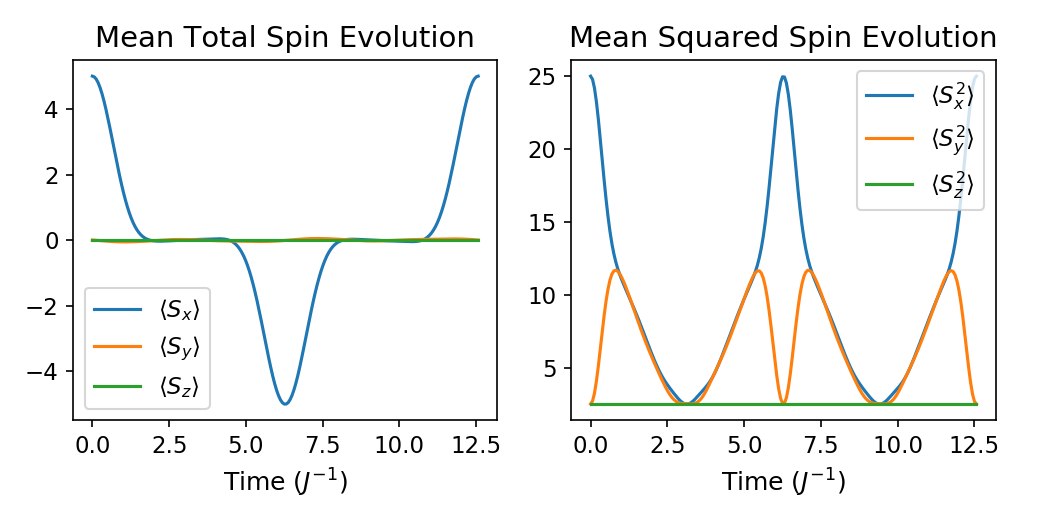

In [11]:
## DTWA PARAMS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
N = 10
nt =  10**4
initAxis = "x"
Jz = -1
alpha = 0  # exponents of power law decay of interactions with distance

tvec = np.linspace(0,4*np.pi,200)

trajectories, meanConfig_evol = IsingEvolve(genInitConfigs(N,nt,axis=initAxis),tvec,Jz,coord=[],alpha=0)


Stot_evol = np.sum(meanConfig_evol,axis=1).real
Ssq_evol = np.mean(np.sum(trajectories,axis=2)**2,axis=1).real

fig,ax = plt.subplots(1,2,figsize=(3.5*2,3.5))
ax[0].plot(tvec,Stot_evol)
ax[0].legend([r'$\langle S_x \rangle$',r'$\langle S_y \rangle$',r'$\langle S_z \rangle$'])
ax[0].set_xlabel(r'Time ($J^{-1}$)')
ax[0].set_title(r'Mean Total Spin Evolution')

ax[1].plot(tvec,Ssq_evol)
ax[1].legend([r'$\langle S_x^2 \rangle$',r'$\langle S_y^2 \rangle$',r'$\langle S_z^2 \rangle$'])
ax[1].set_xlabel(r'Time ($J^{-1}$)')
ax[1].set_title(r'Mean Squared Spin Evolution')

plt.tight_layout()


# <font color="#388CD3"> Comparing ED/Analytics and DTWA </font>

## Time Evolution with Uniform Ising Interactions
----

For the special case of Ising dynamics with uniform all-to-all interactions, one can actually obtain analytic results for the evolution of each spin component $s_i^\alpha (t)$. We will compare these analytic results, which may be computed using the functions returned by `IsingSqueezing(N,Jz)` with the results from the DTWA.

As shown in the plots below, the DTWA results track well with the analytic results, except for the times at which the system is in an Schrodinger cat state.

<IPython.core.display.Javascript object>


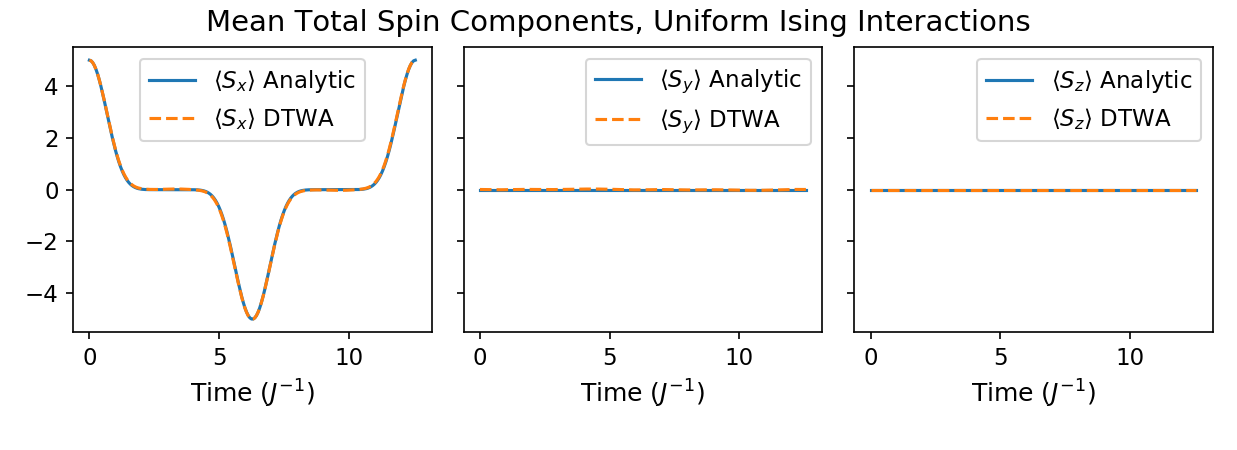

<IPython.core.display.Javascript object>


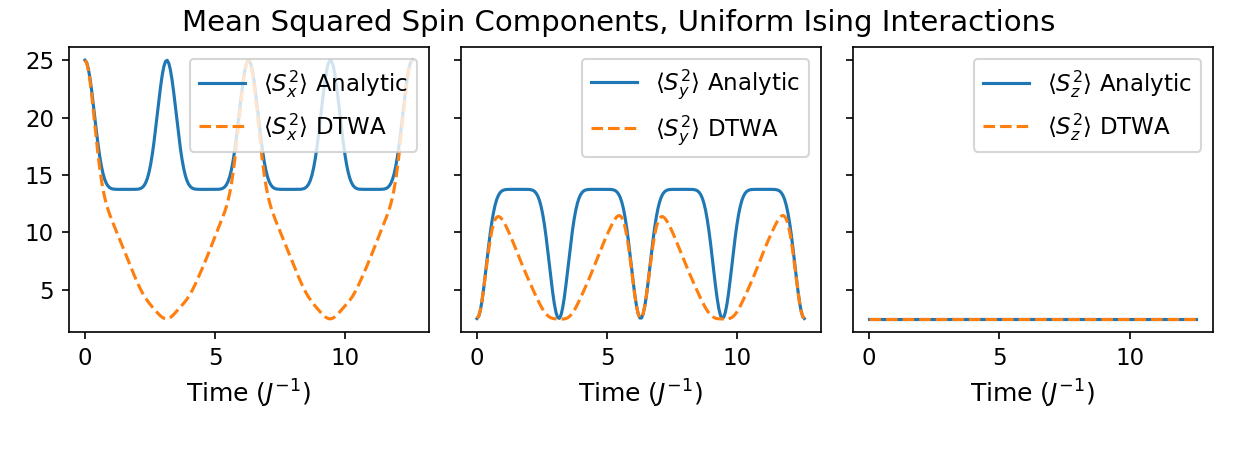

<IPython.core.display.Javascript object>


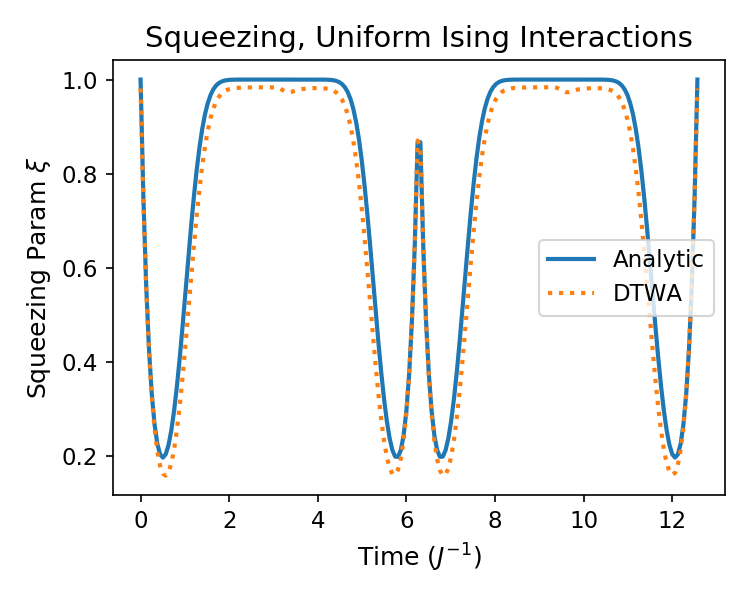

In [15]:
# COMPARISON ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# PARAMS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## DTWA PARAMS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
N = 10       # total number of spins
nt =  10**4  # number of init conditions = number of trajectories
initAxis = "x"

# generate inital spin configs
initConfigs = genInitConfigs(N,nt,axis=initAxis)
tdist, meanConfig_evol = IsingEvolve(initConfigs,tvec,Jz,coord=[],Jfunc=[],alpha=alpha)

# get mean total spin components and their squares
Stot_dtwa = np.sum(meanConfig_evol,axis=1).real.transpose()
Ssq_dtwa = np.mean(np.sum(tdist,axis=2)**2,axis=1).real.transpose()

# obtain quantities used to calculate the squeezing parameter
# W = < {Sy,Sz} > = expectation value of anticommutator
# V± = < Sy^2 ± Sz^2 > = total variance in orthogonal plane (since mean total spin component always points along x) 
W_dtwa = np.array([getW(dist) for dist in tdist]) 
Vp_dtwa = np.array([getVpm(dist,'p') for dist in tdist])
Vm_dtwa = np.array([getVpm(dist,'m') for dist in tdist])
squeezing_dtwa = (Vp_dtwa - np.sqrt(W_dtwa**2 + Vm_dtwa**2))/(N/2)


# ANALYTICS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
squeezing_func,Sx_func, Ssqx_func,Ssqy_func, yz_acomm_func = IsingSqueezing(N,Jz) # get analytic function for squeezing
Stot_an = np.array([Sx_func(tvec),np.zeros_like(tvec),np.zeros_like(tvec)])
Ssq_an = np.array([Ssqx_func(tvec),Ssqy_func(tvec),(N/4)*np.ones_like(tvec)])
squeezing_an = squeezing_func(tvec)

# COMPARISON PLOT  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
mean_labels = [r"$\langle S_x \rangle$",r"$\langle S_y \rangle$",r"$\langle S_z \rangle$"]
meansq_labels = [r"$\langle S_x^2 \rangle$",r"$\langle S_y^2 \rangle$",r"$\langle S_z^2 \rangle$"]

# timestr = time.strftime("%Y-%m-%d-%Hh%Mm%Ss")

fig,ax = plt.subplots(1,3,sharey=True,figsize=(3*2.75,3))
# plt.figure()
for i in range(3):
    ax[i].plot(tvec,Stot_an[i,:],label=mean_labels[i]+" Analytic")
    ax[i].plot(tvec,Stot_dtwa[i,:],"--",label=mean_labels[i]+" DTWA")
#     ax[i].set_title(Stot_labels[i])
    ax[i].set_xlabel(r'Time ($J^{-1}$)')
    ax[i].legend()
plt.suptitle('Mean Total Spin Components, Uniform Ising Interactions')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# fileStr = "StotCompare_Jz_%g_alpha_%g_N_%d_nt_%.2g_%s.png" % (Jz,alpha,N,nt,timestr)
# plt.savefig(fileStr, format='png',bbox_inches = 'tight')


fig,ax = plt.subplots(1,3,sharey=True,figsize=(3*2.75,3))
# plt.figure()
for i in range(3):
    ax[i].plot(tvec,Ssq_an[i,:],label=meansq_labels[i]+" Analytic")
    ax[i].plot(tvec,Ssq_dtwa[i,:],"--",label=meansq_labels[i]+" DTWA")
    ax[i].set_xlabel(r'Time ($J^{-1}$)')
    ax[i].legend()
plt.suptitle('Mean Squared Spin Components, Uniform Ising Interactions')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# fileStr = "SsqCompare_Jz_%g_alpha_%g_N_%d_nt_%.2g_%s.png" % (Jz,alpha,N,nt,timestr)
# plt.savefig(fileStr, format='png',bbox_inches = 'tight')


plt.figure(figsize=(5,4))
plt.plot(tvec,squeezing_an.real,label="Analytic",linewidth=2)
plt.plot(tvec,squeezing_dtwa.real,':',label="DTWA",linewidth=2)
plt.xlabel(r'Time ($J^{-1}$)')
plt.ylabel(r'Squeezing Param $\xi$')
plt.title("Squeezing, Uniform Ising Interactions")
plt.legend();
plt.tight_layout()

# fileStr = "SqueezingCompare_Jz_%g_alpha_%g_N_%d_nt_%.2g.png" % (Jz,alpha,N,nt,timestr)
# plt.savefig(fileStr, format='png',bbox_inches = 'tight')


## Power Law Interactions
-----

Generically, the interaction energies $J_{ij}$ depend on the positional vectors of the spins $\mathbf{r}_i$. Often, the interaction between two spins depends on the displacemement between the two position vectors $J_{ij}(\mathbf{r}_i - \mathbf{r_j})$.

In the example below, we consider non-uniform power-law interactions between the different spins which are placed arranged in a lattice. We restrict ourselves to the case of $N = 16$ to allow for comparison with ED results. However, note that the DTWA can accomodate a larger number of spins with arbitrary geometries, such as lattices in higher dimensions. 


First we select the type of power law interaction. We shall use one that is of the form of a Rydberg interaction, which is a softened step function whose rate of decay depends only on the ratio of the distance between the spins to some critical distance. This power law is generated by `RydbergJfunc(Jz,alpha,rc)` and returns a vectorized function for the interaction of the form


$$ J(r) = J_z\frac{1}{1 + (r/r_c)^\alpha} $$

<IPython.core.display.Javascript object>


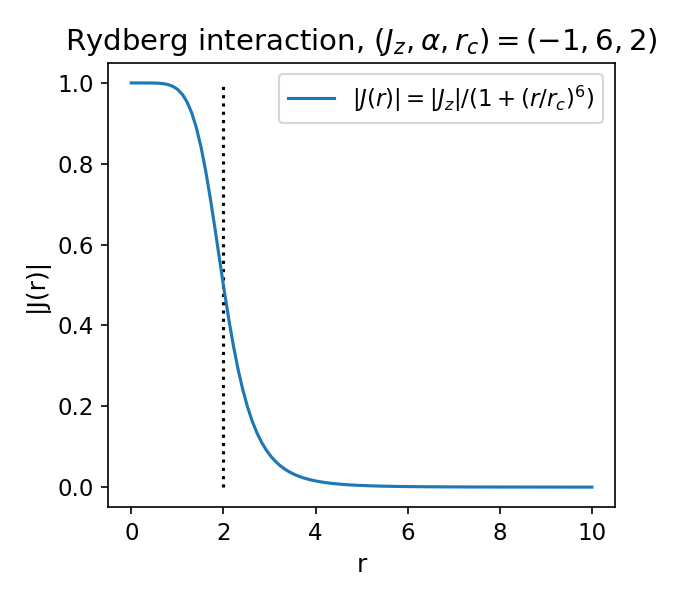

In [19]:
# check power law interaction shape
rvec = np.linspace(0,10,100)
alpha = 6
Jz = -1
rc = 2
plt.figure(figsize=(4.5,4))
Jfunc = RydbergJfunc(Jz,alpha,rc)
plt.plot(rvec,np.abs(Jfunc(rvec)),label=r"$|J(r)|= |J_z|/(1+(r/r_c)^{%.3g}$)"%alpha)
plt.vlines(rc,0,1,linestyles=':')
plt.xlabel('r')
plt.ylabel("|J(r)|")
plt.title(r"Rydberg interaction, $(J_z, \alpha, r_c) =  (%.2g, %.2g, %.2g$)"%(Jz,alpha,rc))
plt.legend()
plt.tight_layout()

# fileStr = "RydbergPowerLawInt_Jz_%g_alpha_%g_rc_%.2g.png" % (Jz,alpha,rc)
# plt.savefig(fileStr, format='png',bbox_inches = 'tight')

Now we actually compute the dynamics. For the spin geometry, we use a 2D lattice of dimension 4x4, giving a total of $N = 16$ spins. The dimensions of the lattice in number of spins are selected by the variable `L`. The interaction energy scale $J_z = -1$, as above, but the actual spin-spin interaction will be computed using the equation above. We find that the DTWA is able to capture the quantum dynamics fairly well even in the presence of power law interactions. In fact, as one increases the total number of spins $N$ the DTWA results have better agreement with the ED numerics.

<IPython.core.display.Javascript object>


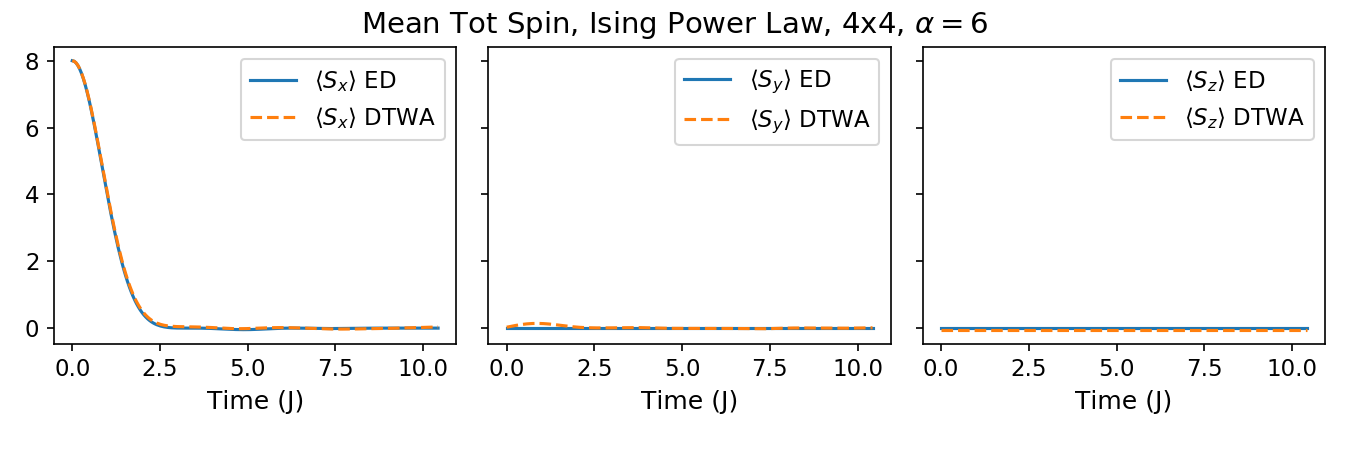

<IPython.core.display.Javascript object>


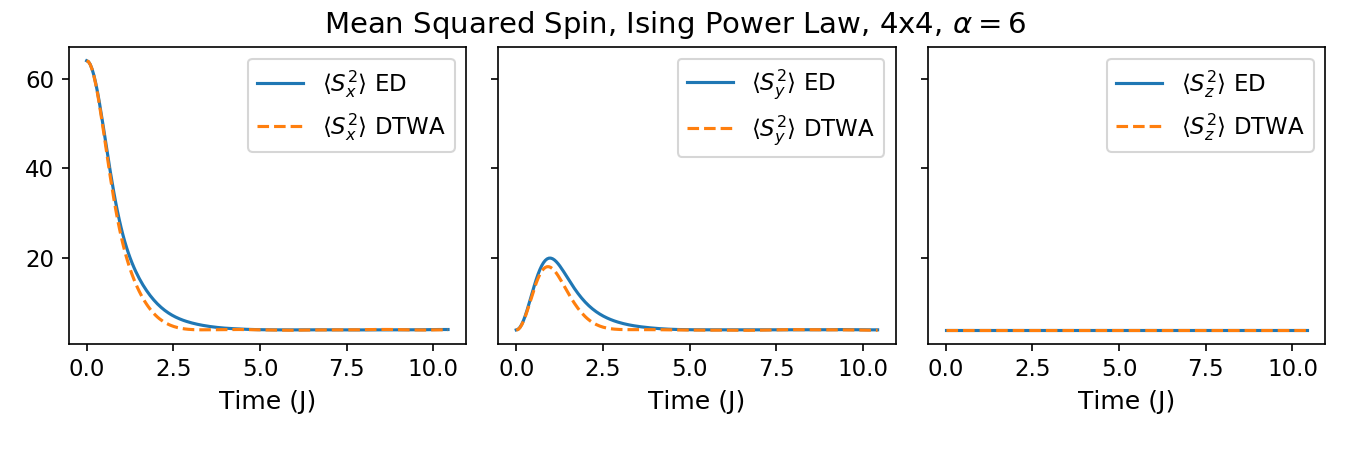

<IPython.core.display.Javascript object>


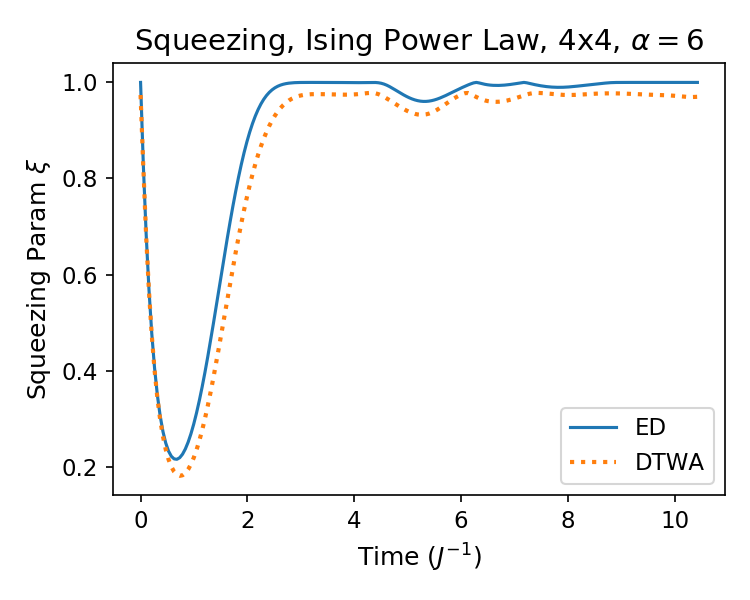

In [20]:
# COMPARISON ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# PARAMS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
L = (4,4)
N = np.prod(L)
Jz = -1
Jperp = (0,0)  # no xx or zz interactions --> their scales are set to 0
hz = 0
hx = 0
coord = getLatticeCoord(2,L,1)  # 4x4 grid of atoms spaced 1 lattice unit apart


tvec = np.linspace(0,3*np.pi+1,200)

# POWER LAW INTERACTION  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
rc = 2
alpha = 6  # exponents of power law decay of interactions with distance
Jfunc = [RydbergJfunc(Jperp[0],alpha,rc),RydbergJfunc(Jperp[1],alpha,rc),RydbergJfunc(Jz,alpha,rc)]

# ED ISING PARAMS  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

H,opList,S_tot_ops = Heisenberg_A2A(L, Jperp,Jz, hx, hz,alpha=alpha,Jfunc=Jfunc,coord=coord)
sx,sy,sz,sp,sm = opList
# # eigs,evecs = IsingEigenstates(H)

x0_state = (1/(2**(N/2)))*np.ones(2**N,)  # all up in x basis
initState = x0_state

Sy_tot = S_tot_ops[1]
Sz_tot = S_tot_ops[2]

S_mean_ed = []
Ssq_mean_ed = []
for i in range(3):
    S_mean_ed.append(np.array([expval_me(Qobj(initState),S_tot_ops[i],H,t) for t in tvec]))
    Ssq_mean_ed.append(np.array([expval_me(Qobj(initState),S_tot_ops[i]*S_tot_ops[i],H,t) for t in tvec]))
#     S_mean_ed.append(np.array([expval(initState,np.array(S_tot_ops[i]),eigs,evecs,t) for t in tvec]))
#     Ssq_mean_ed.append(np.array([expval(initState,np.array(S_tot_ops[i]@S_tot_ops[i]),eigs,evecs,t) for t in tvec]))

S_mean_ed = np.array(S_mean_ed)
Ssq_mean_ed = np.array(Ssq_mean_ed)

W_ed = np.array([expval_me(Qobj(initState),commutator(Sy_tot,Sz_tot,kind="anti"),H,t) for t in tvec])

Vp_ed = Ssq_mean_ed[1,:] + Ssq_mean_ed[2,:]
Vm_ed = Ssq_mean_ed[1,:] - Ssq_mean_ed[2,:]
squeezing_ed = (Vp_ed - np.sqrt(W_ed**2 + Vm_ed**2))/(N/2)

# DTWA ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
nt = 10**4
initAxis = "x"

initConfigs = genInitConfigs(N,nt,axis=initAxis)
tdist, meanConfig_evol = IsingEvolve(initConfigs,tvec,Jz,alpha=alpha,Jfunc=Jfunc[2],coord=coord)

S_mean_dtwa = np.array([np.sum(config,axis=0).real for config in meanConfig_evol]).transpose()
Ssq_mean_dtwa = np.array([np.mean((np.sum(dist,axis=1)**2),axis=0).real for dist in tdist]).transpose()
W_dtwa = np.array([getW(dist) for dist in tdist])
Vp_dtwa = np.array([getVpm(dist,'p') for dist in tdist])
Vm_dtwa = np.array([getVpm(dist,'m') for dist in tdist])
squeezing_dtwa = (Vp_dtwa - np.sqrt(W_dtwa**2 + Vm_dtwa**2))/(N/2)


# COMPARISON PLOTS  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
mean_labels = [r"$\langle S_x \rangle$",r"$\langle S_y \rangle$",r"$\langle S_z \rangle$"]
meansq_labels = [r"$\langle S_x^2 \rangle$",r"$\langle S_y^2 \rangle$",r"$\langle S_z^2 \rangle$"]

timestr = time.strftime("%Y-%m-%d-%Hh%Mm%Ss")


fig,ax = plt.subplots(1,3,sharey=True,figsize=(3*3,3))
for i in range(3):
    ax[i].plot(tvec,S_mean_ed[i,:],label=mean_labels[i]+" ED")
    ax[i].plot(tvec,S_mean_dtwa[i,:],"--",label=mean_labels[i]+" DTWA")
    ax[i].set_xlabel("Time (J)")
    ax[i].legend()
plt.suptitle(r'Mean Tot Spin, Ising Power Law, %s, $\alpha=%g$'%(getDimStr(L),alpha))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# fileStr = "StotComparisonPowerLaw_Jz_%g_alpha_%g_L_%s_nt_%.2g.png" % (Jz,alpha,getDimStr(L),nt)
# plt.savefig(fileStr, format='png',bbox_inches = 'tight')


fig,ax = plt.subplots(1,3,sharey=True,figsize=(3*3,3))
# plt.figure()
for i in range(3):
    ax[i].plot(tvec,Ssq_mean_ed[i,:],label=meansq_labels[i]+" ED")
    ax[i].plot(tvec,Ssq_mean_dtwa[i,:],"--",label=meansq_labels[i]+" DTWA")
    ax[i].set_xlabel("Time (J)")
    ax[i].legend()
plt.suptitle(r'Mean Squared Spin, Ising Power Law, %s, $\alpha=%g$'%(getDimStr(L),alpha))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# fileStr = "SsqComparisonPowerLaw_Jz_%g_alpha_%g_L_%s_nt_%.2g.png" % (Jz,alpha,getDimStr(L),nt)
# plt.savefig(fileStr, format='png',bbox_inches = 'tight')


plt.figure(figsize=(5,4))
plt.plot(tvec,squeezing_ed.real,label="ED")
plt.plot(tvec,squeezing_dtwa.real,':',label="DTWA",linewidth=2)
plt.xlabel(r"Time ($J^{-1}$)")
plt.ylabel(r'Squeezing Param $\xi$')
plt.legend();
plt.title(r'Squeezing, Ising Power Law, %s, $\alpha=%g$'%(getDimStr(L),alpha))
plt.tight_layout()

# fileStr = "SqueezingComparisonPowerLaw_Jz_%g_alpha_%g_L_%s_nt_%.2g.png" % (Jz,alpha,getDimStr(L),nt)
# plt.savefig(fileStr, format='png',bbox_inches = 'tight')

# <font color="#388CD3"> Visualization </font>

## Marginal Probability Distributions
---

One may be interested in the probability distribution of the components of the _total_ spin vector. Recall that the DTWA yields a probability distribution for _each_ component of _each_ spin $s_i^\alpha, \alpha = x,y,z$. One simply needs to sum up the corresponding components of all the spins to obtain the total spin components $S_x$, $S_y$, and $S_z$ for each of the trajectories/initial conditions. Then, averaging these over all the trajectories gives the mean total spin component $\langle S_i^\alpha \rangle$.


Consider the initial spin-polarized state in the $x$ direction. The distribution over the set of possible initial conditions consistent with this state (according to the DTWA Monte Carlo prescription) should give an approximately binomial distribution for the total spin components $S_{y,z} = \sum_i s_i^{y,z}$ in the limit of a large number of initial conditions. We can plot this as a histogram and see that this is indeed the case.

<IPython.core.display.Javascript object>


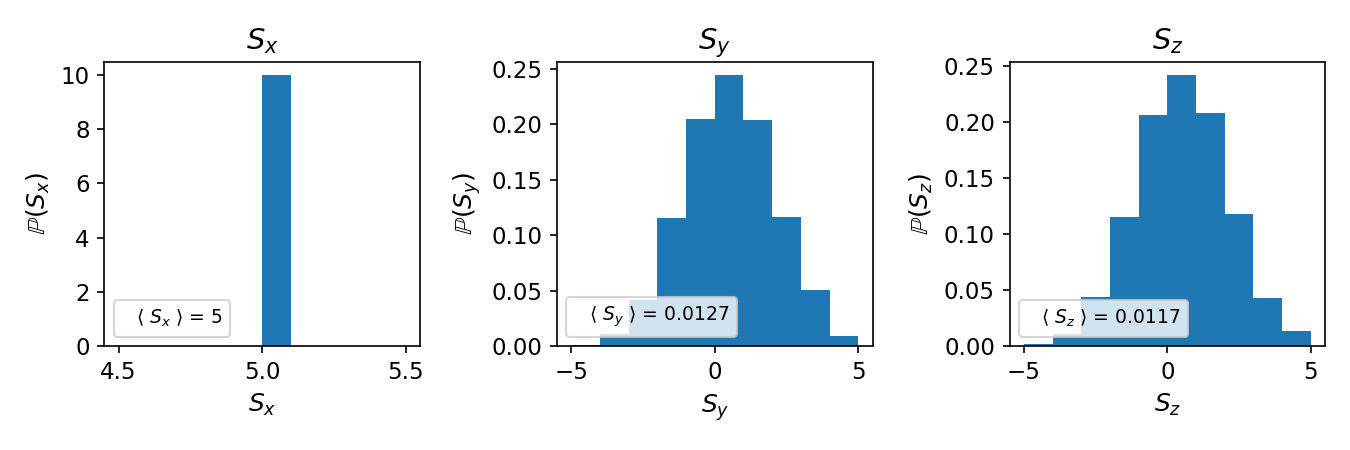

In [27]:
# DTWA ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
nt = 10**4
initAxis = "x"

initConfigs = genInitConfigs(N,nt,axis=initAxis)
Stot_config = np.sum(initConfigs,1)

# INITIAL MARGINAL DIST HISTOGRAMS  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
labels = ["$S_x$","$S_y$","$S_z$"]
fig,ax = plt.subplots(1,Stot_config.shape[1],figsize=(3*Stot_config.shape[1],3))
for i in range(Stot_config.shape[1]):
    labelStr = r"$\langle$ %s $\rangle$ = %g" % (labels[i], np.mean(Stot_config[:,i]));
    ax[i].hist(Stot_config[:,i],bins=10,label=labelStr,density=1)
    ax[i].set_xlabel(labels[i])
    ax[i].set_ylabel(r'$\mathbb{P}$(%s)'%labels[i])
    ax[i].set_title(labels[i])
    ax[i].legend(handlelength=0,loc = "lower left",prop={'size': 9});
plt.tight_layout()

## Bloch Sphere Probability Distributions
----

One may choose to visualize the probability distribution of the TOTAL spin components $\mathbf{S} = (S_x, S_y, S_z)$ on the Bloch sphere. This is made easy by the `visualizeBloch()` function of the package, located in `DTWA_Lib`. Given some number $n_t$ of system configurations, one can find the total spin vector for each of these configurations, and plot them as a point in 3D. Note that because each spin component can only take on values of $\pm\frac{1}{2}$, the set of all possible total spin vectors is discrete. In the plot below intensity of color at each point, which corresponds to one possible total spin vector, corresponds to its probability. The `visualizeBloch` function also has a set of options that allows one to turn on/off axesLabels, projections onto each of the 2D planes, and axes lines, as well as  changing the viewing angle.

<IPython.core.display.Javascript object>


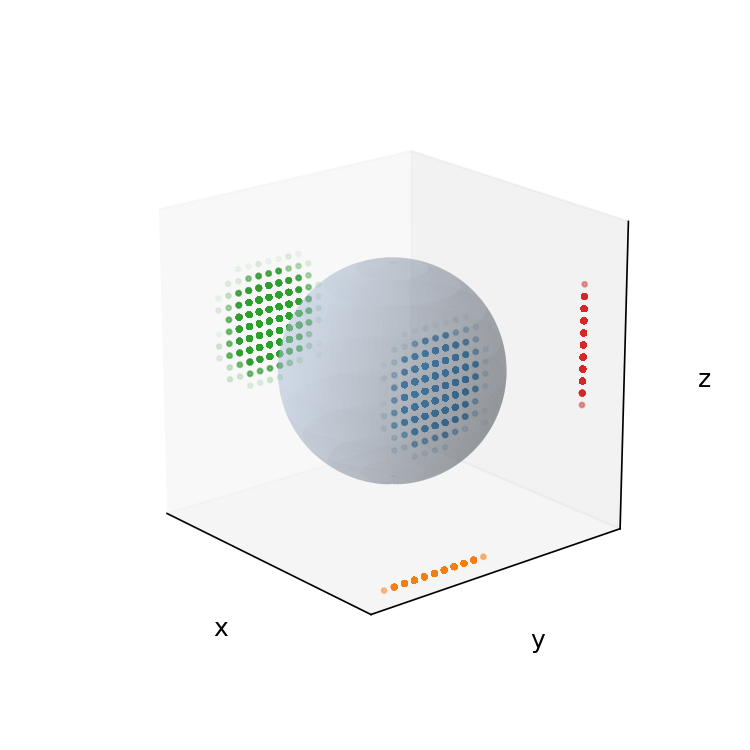

In [22]:
N = 10
nt =  10**4
initAxis = "x"

initConfigs = genInitConfigs(N,nt,axis=initAxis)

elev,azim = (20,-40)
sphere,ax = visualizeBloch(initConfigs,axesLabels=True,showAxes=True,viewAngle=(elev,azim),showProjection=True)

# fileStr = "InitStotBloch_axis_%s_Jz_%g_L_%g_nt_%.3g.png" % (initAxis,Jz,N,nt)
# plt.savefig(fileStr, format='png',bbox_inches = 'tight')

We can also see what the probability distribution looks like at some later point in time. As an example, we will look at the distribution near the time of optimal squeezing after evolving under Ising Hamiltonian with uniform interactions.

<IPython.core.display.Javascript object>


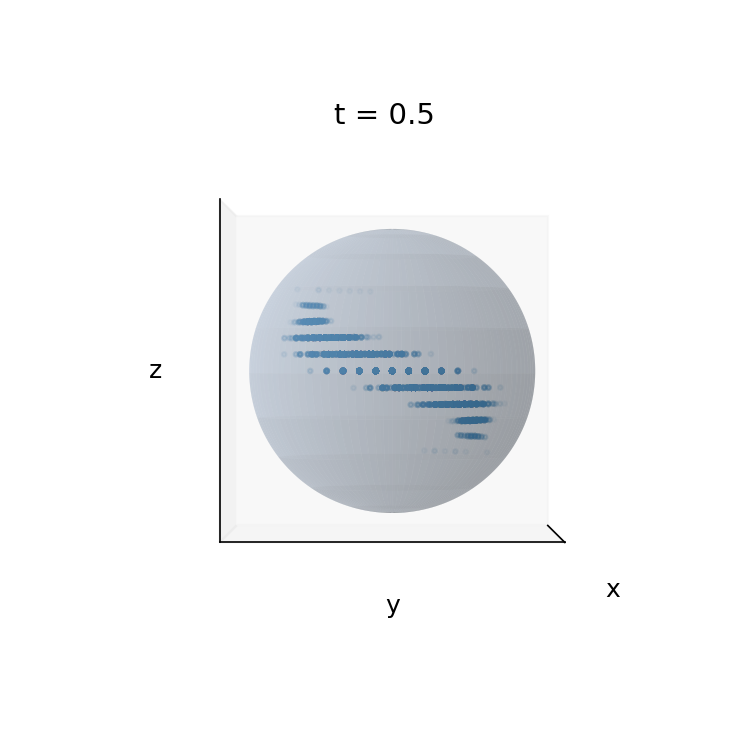

In [23]:
N = 10
nt =  10**4
initAxis = "x"
Jz = -1

initConfigs = genInitConfigs(N,nt,axis=initAxis)

t_squeezed = [0.5] # choose time to compute the configuration at; must be a array/list even if a single time point for IsingEvolve()
tdist,_ = IsingEvolve(initConfigs,t_squeezed,Jz,coord=[],alpha=0); # compute evolution
visualizeBloch(tdist[0],t_squeezed[0],viewAngle=(0,0),axesLabels=True,showProjection=False);

# fileStr = "Bloch_Squeezed_N_%g_nt_%.2g.png" % (N,nt)
# plt.savefig(fileStr, format='png',bbox_inches = 'tight')

## Animations
---

Given the ability to look at the probability distribution of $\mathbf{S}$ on the Bloch sphere at an arbitrary point in time, one can now generate an animation showing how this distribution evolves under any Hamiltonian. This is facilitated by the function `animateBloch` which automatically generates a set of frames based on the configurations at each given point in time. These configurations are all of the trajectories simulated by the DTWA, outputted by the functions which compute evolution under a particular Hamiltonian (e.g. `IsingEvolve()`, `XYEvolve`, `TFEvolve`). The frames may then be put together and saved as a gif.

Run the code block below to generate an animated gif of the probability distribution of the total spin vector under Ising dynamics.

In [7]:
N = 10
Jz = -1
nt = 10**4

initConfigs = genInitConfigs(N,nt)

tgif = np.linspace(0,3*np.pi+1,300)
tdist_gif, _ = IsingEvolve(initConfigs,tgif,Jz,coord=[],alpha=0)
showProj = True
filenameStr = "./animateBloch_proj_%s_N_%d_nt_%.2g_tmax_%.2g.gif" % (showProj,tdist_gif[0].shape[1],tdist_gif[0].shape[0],tgif[-1])
elev,azim = (30,-45)
# elev,azim = (0,-1)
ImList_shortTime = animateBloch(tgif,tdist_gif,sphere=[],viewAngle=(elev,azim),showProjection=showProj,axesLabels=True,showAxes=True,saveBool=True,filename=filenameStr,fps=4)
imageio.mimsave(filenameStr,ImList_shortTime,fps=5)

/Users/tamran/Documents/Stanford/Monika Rotation/DTWA Library/DTWA_Lib.py:261: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


#  <font color="#388CD3"> Benchmarking </font>

## Runtime Scaling with System Size 
----

Here we show how the runtime of the DTWA scales with system size. We separately consider:

1. the time it takes to initialize all of the trajectories to be simulated (i.e. the time it takes to generate $n_t$ initial conditions)
2. the time it takes to simulate a _fixed_ number of time points in the evolution. This informs us about how much time it takes to apply the EOM for each of the $N$ spins. 

Below we examine the runtime vs. the system size, averaged from 20 different trials of executing the DTWA under the uniform all-to-all Ising Hamiltonian. We see that the initialization scales negligibly with system size but that the evolution itself does scale weakly with $N$. This makes sense because initializing the configurations is done by simply initializing a random matrix of the appropriate dimensions, while the evolution must be computed for each of the $N$ spins.

Running L = 8
Running L = 10
Running L = 12
Running L = 16
Running L = 20
Running L = 30
Running L = 40
Running L = 50
Running L = 60


<IPython.core.display.Javascript object>


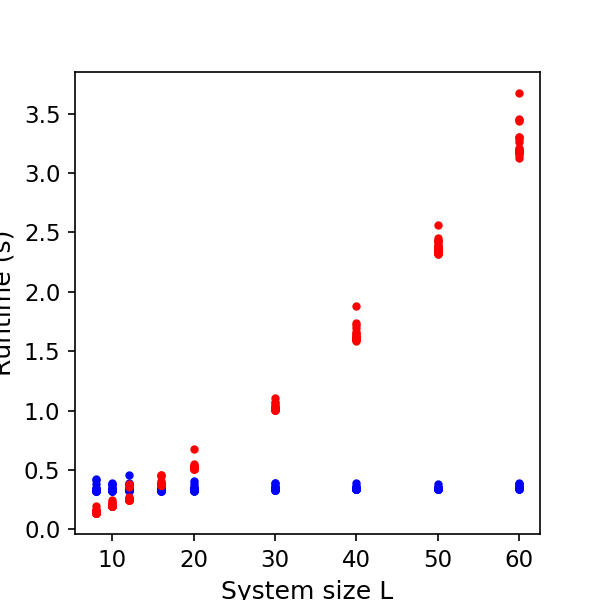

<IPython.core.display.Javascript object>


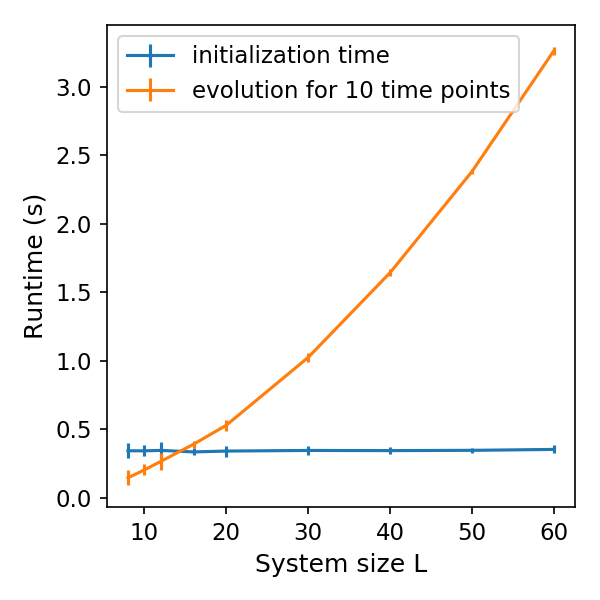

In [24]:
# RUNTIME SCALING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ntrials = 20
Lvec = [8,10,12,16,20,30,40,50,60]
nt = 10**4
initAxis = "x"
Jz = -1
alpha = 0
tvec = np.linspace(0,2*np.pi,10)


## TIME TO CREATE INITIAL CONFIGS
tinit_vec = np.zeros((len(Lvec),ntrials))
tevolve_vec = np.zeros((len(Lvec),ntrials))
for i,L in enumerate(Lvec):
    print("Running L = %d" %L)
    for n in range(ntrials):
        start = time.time()
        initConfigs = genInitConfigs(L,nt,axis=initAxis)
        end = time.time()
        tinit_vec[i,n]= end-start
        
        start = time.time()
        _, _ = IsingEvolve(initConfigs,tvec,Jz,coord=[],alpha=0)
        end = time.time()
        tevolve_vec[i,n] = end-start
        
                                
plt.figure(figsize=(4,4))
plt.plot(np.array([Lvec,]*ntrials),tinit_vec.T,'b.');
plt.plot(np.array([Lvec,]*ntrials),tevolve_vec.T,'r.');
plt.xlabel("System size L")
plt.ylabel("Runtime (s)")

# timestr = time.strftime("%Y-%m-%d-%Hh%Mm%Ss")
# fileStr = "RuntimeScaling_Scatter_nt_%.2g_%s.png" % (nt,timestr)
# plt.savefig(fileStr, format='png',bbox_inches = 'tight')

plt.figure(figsize=(4,4))
plt.errorbar(Lvec,np.mean(tinit_vec,axis=1),2*np.sqrt(np.var(tinit_vec,axis=1)),label="initialization time")
plt.errorbar(Lvec,np.mean(tevolve_vec,axis=1),2*np.sqrt(np.var(tinit_vec,axis=1)),label="evolution for 10 time points")
plt.legend();
plt.xlabel("System size L");
plt.ylabel("Runtime (s)");
plt.tight_layout()

# fileStr = "MeanRuntimeScaling_nt_%.2g_%s.png" % (nt,timestr)
# plt.savefig(fileStr, format='png',bbox_inches = 'tight')

## Convergence with Number of Samples
---

We would like to use some metric to evaluate how well the DTWA is able to authentically capture quantum dynamics. **In particular, we want to see if the DTWA is better able to capture quantum correlations that wouldn't otherwise be captured by a simulation of classical spins.**

One good way to measure this--at least in the case of Ising dynamics--is by examining the squeezing parameter for the DTWA and ED. This is because the squeezing parameter essentially quantifies the amount quantum correlations that develop between the individual spins in the many-body system. These correlations lead to reduced uncertainty in one quadrature (below half the Heisenberg limit of $\hslash$ /2).

**When comparing the squeezing parameter computed by DTWA and ED, one may be interested to see if this error has any dependence on either 1) the number of samples/trajectories used in the DTWA 2) the system size. First, we shall examine how well the DTWA performs for different numbers of trajectories. <font color=blue>The conclusion is that the number of samples reduces the variance among the different DTWA trials, but does not significantly impact its accuracy with respect to ED beyond a certain number of trajectories. In this case, ~10$^3$ trajectories is sufficient to get good agreement with the ED results.</font>**


current # trajectories nt: 100
current # trajectories nt: 500
current # trajectories nt: 1000
current # trajectories nt: 5000
current # trajectories nt: 10000
current # trajectories nt: 28000
current # trajectories nt: 46000
current # trajectories nt: 64000
current # trajectories nt: 82000
current # trajectories nt: 100000


<IPython.core.display.Javascript object>


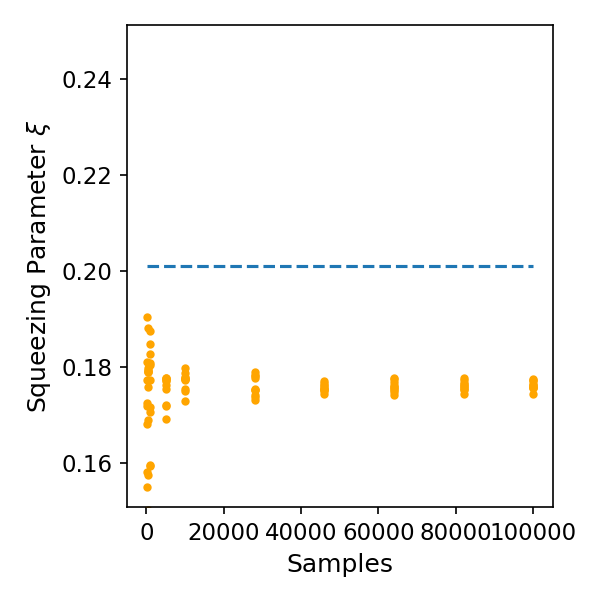

<IPython.core.display.Javascript object>


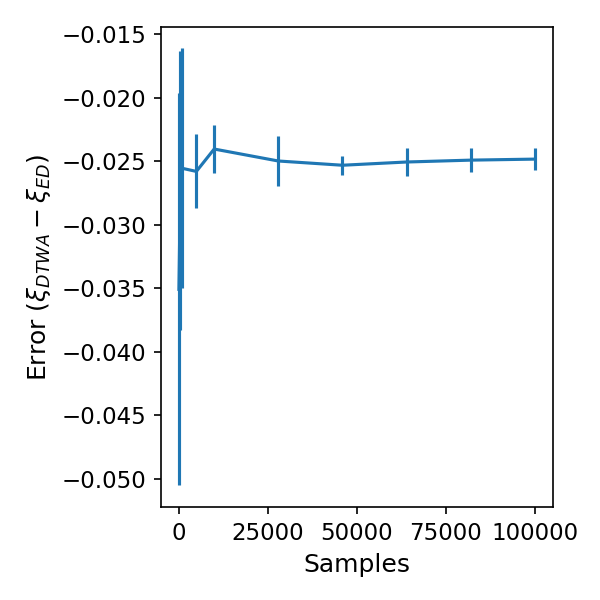

<IPython.core.display.Javascript object>


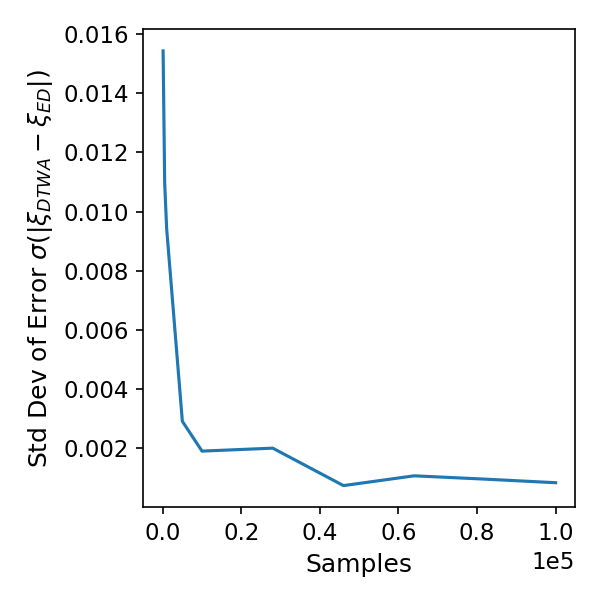

In [31]:
# SCALING OF ERROR WRT ED FOR DIFF nt ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# PARAMS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

L = 10
N = np.prod(L)
Jz = -1
alpha = 0  # exponents of power law decay of interactions with distance
tvec = np.linspace(0.1,0.45,100)  # best squeezing is within this time range


# ANALYTICS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
squeezing_func,Sx_func, _,_, _ = IsingSqueezing(N,Jz) # get analytic function for squeezing
# S_mean_an = np.array([Sx_func(tvec),np.zeros_like(tvec),np.zeros_like(tvec)])
# Ssq_mean_an = np.array([Ssqx_func(tvec),Ssqy_func(tvec),(L/4)*np.ones_like(tvec)])
squeezing_an = np.min(squeezing_func(tvec))
    
# DTWA PARAMS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ntrials = 10
nt_vec = np.concatenate(([100,500,1000,5000],np.linspace(10**4,10**5,6).astype(int)))
initAxis = "x"
squeezing_dtwa = []
for nt in nt_vec:
    print("current # trajectories nt: %g" % nt)
    squeezing_dtwa.append([getDTWASqueezingParam(N,nt,tvec,Jz,coord=[],Jfunc=[],alpha=[])[0] for n in range(ntrials)])
squeezing_dtwa = np.array(squeezing_dtwa)

# Error
absError_squeezing = squeezing_dtwa - squeezing_an                          

plt.figure(figsize = (4,4))
plt.plot(nt_vec,squeezing_dtwa,'.',color='orange',label=r"$\xi_{DTWA}$");
plt.plot(nt_vec,squeezing_an*np.ones((len(nt_vec,))),'--',label=r"\xi_{ED}")
plt.ylim([squeezing_an*(1-0.25),squeezing_an*(1+0.25)])
plt.xlabel("Samples")
plt.ylabel(r"Squeezing Parameter $\xi$")
plt.tight_layout()

# fileStr = "SqueezingNtDependence_Jz_%g_alpha_%g_N_%d_ntrials_%d.png" % (Jz,alpha,N,ntrials)
# plt.savefig(fileStr, format='png',bbox_inches = 'tight')


plt.figure(figsize = (4,4))
# plt.plot(nt_vec,absError_squeezing,'b.')
plt.errorbar(nt_vec,np.mean(absError_squeezing,axis=1).real,yerr=np.sqrt(np.var(absError_squeezing,axis=1).real),label="mean absolute eror");
plt.xlabel("Samples")
plt.ylabel(r"Error ($\xi_{DTWA}-\xi_{ED}$)")
plt.tight_layout()

# fileStr = "MeanSqueezingErrorNt_Jz_%g_alpha_%g_N_%d_ntrials_%d.png" % (Jz,alpha,N,ntrials)
# plt.savefig(fileStr, format='png',bbox_inches = 'tight')


plt.figure(figsize = (4,4))
plt.plot(nt_vec,np.sqrt(np.var(absError_squeezing,axis=1)))
plt.xlabel("Samples")
plt.ylabel(r"Std Dev of Error $\sigma(|\xi_{DTWA}-\xi_{ED}|)$")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.tight_layout()

# fileStr = "SDSqueezingErrorNt_Jz_%g_alpha_%g_N_%d_ntrials_%d.png" % (Jz,alpha,N,ntrials)
# plt.savefig(fileStr, format='png',bbox_inches = 'tight')

## Convergence with System Size 
----
**Now we shall examine how the accuracy of the DTWA scales with system size for uniform Ising interactions, again using the squeezing parameter as our metric. <font color=blue> In the plots below, we see that the squeezing parameter computed by the DTWA is more accurate with increasing system size, with the error decaying as $\approx L^{-1}$.</font>** The first plot shows a comparison of the squeezing parameter time-evolution for different system sizes computed analytically (solid lines) and using the DTWA (dashed lines). If one tracks the optimal (i.e. smallest) squeezing parameter from the analytic evolution, one finds see that its scales as $L^{-2/3}$, as expected. Then, comparing the difference between the optimal squeezing parameter for DTWA and the analytic result shows that the error drops as $1/L$.

/Users/tamran/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


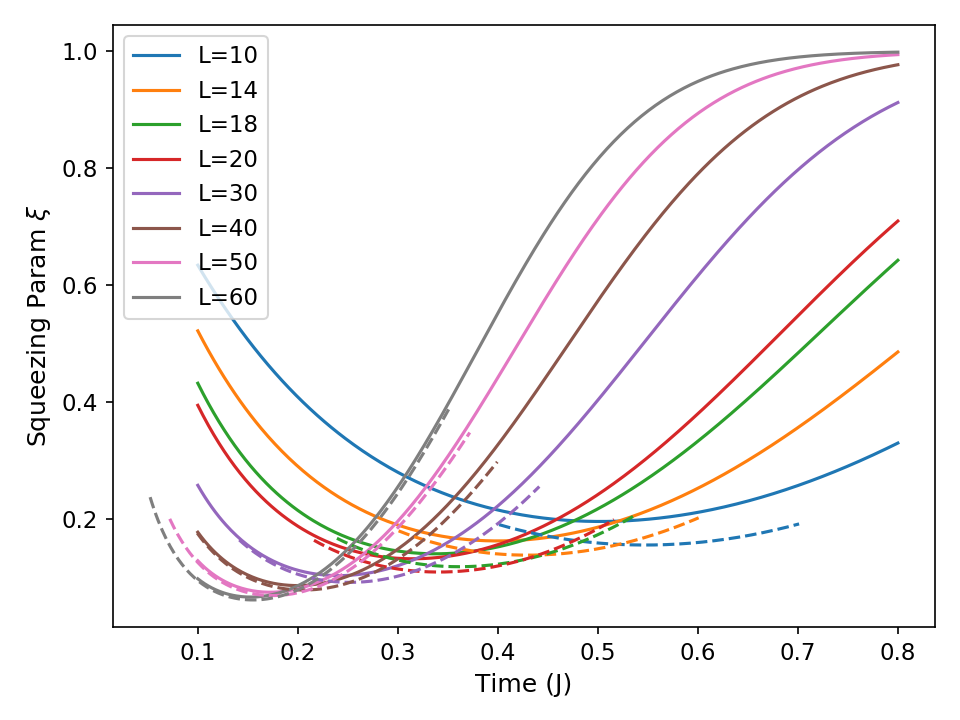

/Users/tamran/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


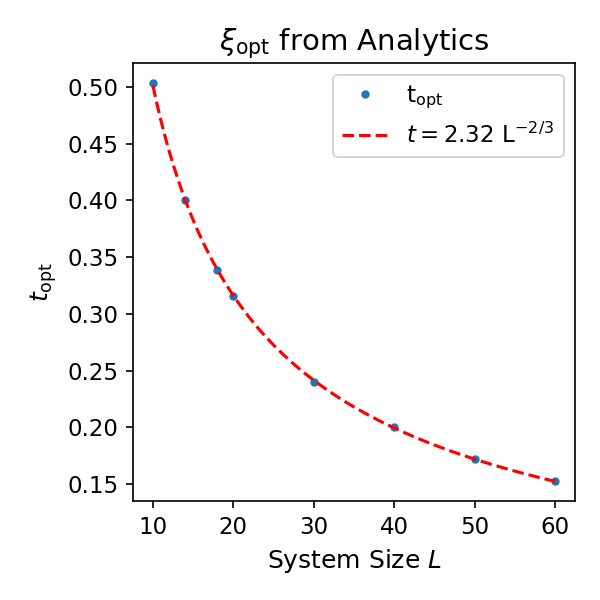

DTWA L=10
10
DTWA L=14
10
DTWA L=18
10
DTWA L=20
10
DTWA L=30
10
DTWA L=40
10
DTWA L=50
10
DTWA L=60
10


/Users/tamran/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


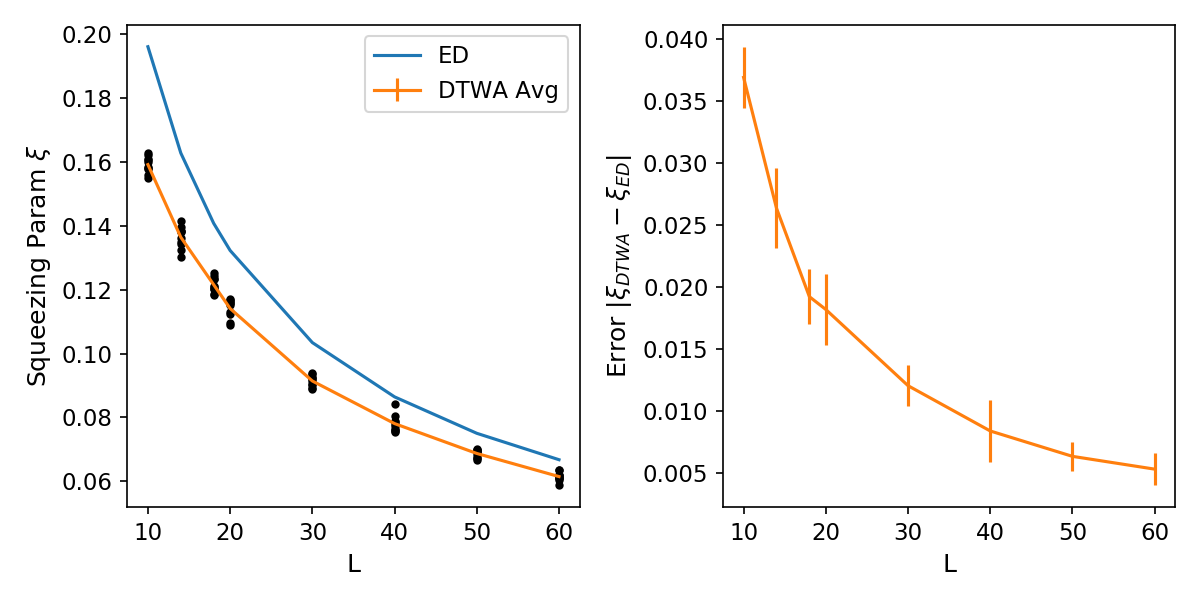

[ 4.29998406e-01 -1.06412218e+00  1.21115329e-08]


/Users/tamran/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


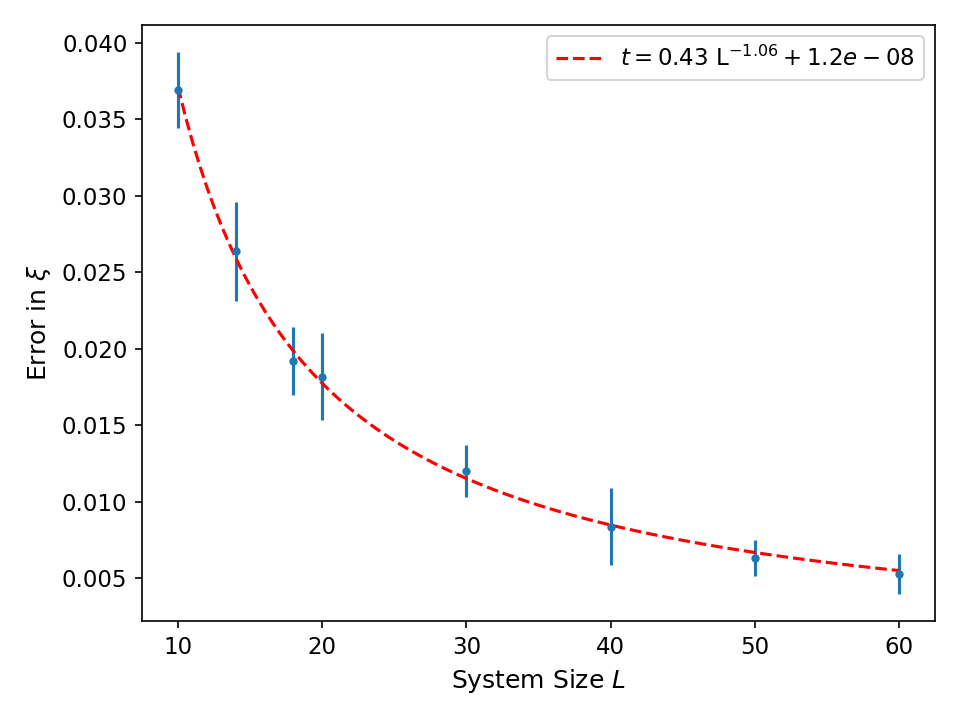

In [37]:
# COMPARE SQUEEZING VS L ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Lvec = [10,14,18,20,30,40,50,60]
Jperp = 0
Jz = -1 # ferromagnetic
hz = 0
hx = 0
initAxis = 'x'
alpha = 0  # exponent of power law decay of interactions with distance

# Analytics ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
tvec_an = np.linspace(0.1,0.8,400)
squeezing_an = []
squeezingTimes = []
fig1 = plt.figure()
colors = []
for L in Lvec:
    color = next(plt.gca()._get_lines.prop_cycler)['color']
    colors.append(color)
#     print("Analytics L=%d" % L)
    squeezing_func,_, _, _, _ = IsingSqueezing(L,Jz) # get analytic function for squeezing
    squeezing_evol = squeezing_func(tvec_an)
    plt.plot(tvec_an,squeezing_evol,color=color,label="L=%d"%L)
    squeezingParam = np.min(squeezing_evol)
    squeezingTimes.append(tvec_an[np.argmin(squeezing_evol)])
    squeezing_an.append(squeezingParam)
plt.legend();


# Extract power law dependence of the optimal squeezing time
powerLaw = lambda x, A, b: A * (x**b) # Define function for calculating a power law
logx = np.log10(Lvec)
logy = np.log10(squeezingTimes)
fitParams = np.polyfit(logx,logy,1);
b = fitParams[0];
A = 10**(fitParams[1]);
fig2 = plt.figure(figsize=(4,4))
plt.plot(Lvec,squeezingTimes,'.',label = r'$\mathrm{t_{opt}}$')
pwrFrac = Fraction(b).limit_denominator(10)  # get rational approximation to power law exponent as a tuple
Lmodel = np.linspace(min(Lvec),max(Lvec),100)
plt.plot(Lmodel,powerLaw(Lmodel,A,b),'r--',label=r"$t = %.3g$ L$^{%d/%d}$"%(A,pwrFrac.numerator,pwrFrac.denominator))
plt.xlabel(r'System Size $L$')
plt.ylabel(r'$t_\mathrm{opt}$')
plt.title(r'$\xi_{\mathrm{opt}}$ from Analytics')
plt.legend()
plt.tight_layout()


# DTWA ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
nt = 10**4  # number of trajectories in DTWA
ntrials = 10 # will average squeezing param obtained from dtwa over 10 trials
squeezing_dtwa_trials = []

plt.figure(fig1.number)
for i,L in enumerate(Lvec):
    # use predicted t_opt to select a range of times to evolve using the DTWA to speed up computation
    topt = powerLaw(L,10**fitParams[1],fitParams[0])
    tvec = np.linspace(max(0,topt-0.1),topt+0.2,150)

    print("DTWA L=%d"%L)
    squeezingParam_dtwa,squeezingvec_dtwa = getDTWASqueezingParam(L,nt,tvec,Jz,coord=[],Jfunc=[],alpha=[])
    plt.plot(tvec,squeezingvec_dtwa,"--",color=colors[i])
    params_trials = [squeezingParam_dtwa] + [getDTWASqueezingParam(L,nt,tvec,Jz,coord=[],Jfunc=[],alpha=[])[0] for n in range(ntrials-1)]
    print(len(params_trials))
    squeezing_dtwa_trials.append(params_trials)

plt.xlabel("Time (J)")
plt.ylabel(r"Squeezing Param $\xi$")
plt.legend();
plt.tight_layout()

squeezing_dtwa_trials = np.array(squeezing_dtwa_trials)

meanSqueezing_dtwa = np.mean(squeezing_dtwa_trials,axis=1)
varSqueezing_dtwa = np.var(squeezing_dtwa_trials,axis=1)

fig,ax = plt.subplots(1,2,figsize=(4*2,4))

ax[0].plot(Lvec,squeezing_an,label="ED")
color = next(ax[0]._get_lines.prop_cycler)['color']
ax[0].plot(Lvec,squeezing_dtwa_trials,'k.')
ax[0].errorbar(Lvec,meanSqueezing_dtwa ,yerr=np.sqrt(varSqueezing_dtwa),label="DTWA Avg",color=color)
ax[0].set_xlabel("L")
ax[0].set_ylabel(r"Squeezing Param $\xi$")
ax[0].legend();

squeezingError = np.abs(meanSqueezing_dtwa - squeezing_an)
ax[1].errorbar(Lvec,squeezingError, yerr=np.sqrt(varSqueezing_dtwa),color=color)
ax[1].set_xlabel("L")
ax[1].set_ylabel(r"Error $\left|\xi_{DTWA}-\xi_{ED}\right|$")

plt.tight_layout()


# timestr = time.strftime("%Y-%m-%d-%Hh%Mm%Ss")
# fileStr = "SqueezingErrorVsL_Jz_%g_alpha_%g_nt_%.2g_trials_%.2g_Lmax_%d.png" % (Jz,alpha,nt,ntrials,max(Lvec))
# plt.savefig(fileStr, format='png',bbox_inches = 'tight')

# EXTRACT PWR LAW OF ERROR VS L ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

powerLawShift = lambda x, A, b, e: A * (x**b) + e # power law on top of a flat curve

bounds = ([0,-np.inf,0],[np.inf,np.inf,np.inf])
fitParams,_ = scipy.optimize.curve_fit(powerLawShift, np.array(Lvec), squeezingError,p0=[2,-1.1,.005], bounds = bounds) 
print(fitParams)
A_error = fitParams[0]
b_error = fitParams[1]
e_error = fitParams[2]

plt.figure()
plt.errorbar(Lvec,squeezingError,fmt='.',yerr=np.sqrt(varSqueezing_dtwa))

pwrFrac_error = Fraction(b_error).limit_denominator(1000)  # get rational approximation to power law exponent as a tuple

Lmodel = np.linspace(min(Lvec),max(Lvec),100)
plt.plot(Lmodel,powerLawShift(Lmodel,A_error,b_error,e_error),'r--',label=r"$t = %.3g$ L$^{%.3g} + %.2g$"%(A_error,b_error,e_error))
plt.xlabel(r'System Size $L$')
plt.ylabel(r'Error in $\xi$')
plt.legend()
plt.tight_layout()

# fileStr = "ErrorScalingVsL_Jz_%g_alpha_%g_nt_%.2g_trials_%.2g_Lmax_%d.png" % (Jz,alpha,nt,ntrials,max(Lvec))
# plt.savefig(fileStr, format='png',bbox_inches = 'tight')